In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset, DataLoader

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
np.random.seed(1337)
from google.colab import drive
# This will prompt for authorization.
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## CREAR UNA CARPETA EN DRIVE LLAMADA "Desafio_3" EN DRIVE CON TODOS LOS ARCHIVOS (.py y .csv junto con Notebook)

In [ ]:
cd /content/drive/MyDrive/Desafio_3

In [5]:
from airlineUtils import display_results

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [7]:
class AirlineDataset(Dataset):
    def __init__(self, dataset_path, input_length):
        super().__init__()
        
        self.input_length = input_length
        
        self._dataset = self._read_dataset(dataset_path)
        self.min_passengers = self._dataset.passengers.min()
        self.max_passengers = self._dataset.passengers.max()
    
    def normalize(self, data):
        return (data - self.min_passengers) / (self.max_passengers - self.min_passengers)
    
    def inverse_normalize(self, data):
        return data * (self.max_passengers - self.min_passengers) + self.min_passengers
        
    def _read_dataset(self, dataset_path):
        dataset_df = pd.read_csv(dataset_path)
        dataset_df.columns = ("month", "passengers")
        return dataset_df
    
    def __len__(self):
        return len(self._dataset) - self.input_length
    
    def __getitem__(self, idx):
        target_idx = idx + self.input_length
        prev_data = self._dataset.iloc[idx:target_idx].passengers.to_numpy()
        target = self._dataset.iloc[target_idx]
        return {
            "prev_data": torch.tensor(self.normalize(prev_data), dtype=torch.float),
            "target": torch.tensor(self.normalize(target.passengers), dtype=torch.float),
            "month": target.month
        }

In [8]:
class RNN2(nn.Module): # RNN con capa de dropout de 0.3, modificable
    def __init__(self, input_dim, hidden_dim, num_layers, drop=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop)
        self.linear_out = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        out = self.linear_out(hidden_state.squeeze())
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden

In [9]:
class RNN3(nn.Module): # RNN con capa full connected
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(100, 100)
        self.linear_out = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        out = self.linear_out(hidden_state.squeeze())
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden

In [10]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear_out = nn.Linear(hidden_dim, 1)

    def forward(self, input):
        batch_size, _ = input.size()
        h0 = self.init_hidden(batch_size)
        _, hidden_state = self.rnn(input.unsqueeze(2), h0)
        out = self.linear_out(hidden_state.squeeze())
        return out

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(DEVICE)
        return hidden

In [11]:
def main(seq_len=96, rnn_type=1, drop=0.3, i=0,maxiter=10 ):
    t0 = time.perf_counter()
    # A continuación se definen un par de constantes
    DATASET_PATH = "./international-airline-passengers.csv"
    HISTORY_LENGTH = 4
    TEST_START_IDX = seq_len - HISTORY_LENGTH
    VAL_SPLIT = 0.1

    INPUT_DIM = 1
    HIDDEN_DIM = 4
    NUM_LAYERS = 1

    EPOCHS = 1000
    BATCH_SIZE = 8
    LEARNING_RATE = 0.005

    # Se lee el dataset y definen splits de train/val/test
    airline_ds = AirlineDataset(DATASET_PATH, HISTORY_LENGTH)
    train_val_ds = Subset(airline_ds, range(TEST_START_IDX))
    test_ds = Subset(airline_ds, range(TEST_START_IDX, len(airline_ds)))
    val_start_idx = int((1 - VAL_SPLIT) * len(train_val_ds))
    train_ds = Subset(train_val_ds, range(val_start_idx))
    val_ds = Subset(train_val_ds, range(val_start_idx, len(train_val_ds)))

    print("Size of train/val/test: ", len(train_ds), len(val_ds), len(test_ds))

    airline_dl = DataLoader(
        airline_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True)
    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)
    test_dl = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False)

    # Se instancia el modelo, pérdida y optimizador

    if rnn_type==1:
      rnn = RNN( # RNN, RNN2, RNN3
          input_dim=INPUT_DIM,
          hidden_dim=HIDDEN_DIM,
          num_layers=NUM_LAYERS)
      rnn.to(DEVICE)
      criterion = nn.MSELoss()
      optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

    if rnn_type==2:

      rnn = RNN2( # RNN, RNN2, RNN3
          input_dim=INPUT_DIM,
          hidden_dim=HIDDEN_DIM,
          num_layers=NUM_LAYERS, drop=drop)
      rnn.to(DEVICE)
      criterion = nn.MSELoss()
      optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

    if rnn_type==3:

      rnn = RNN3( # RNN, RNN2, RNN3
          input_dim=INPUT_DIM,
          hidden_dim=HIDDEN_DIM,
          num_layers=NUM_LAYERS)
      rnn.to(DEVICE)
      criterion = nn.MSELoss()
      optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        test_losses = []
        for batch in train_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            loss = criterion(predicted.squeeze(), target)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_train_loss = np.mean(train_losses)
        with torch.no_grad():
            for batch in val_dl:
                prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
                predicted = rnn(prev_data)
                loss = criterion(predicted.squeeze(), target)
                val_losses.append(loss.item())
            mean_val_loss = np.mean(val_losses)
        if epoch % 10 == 0:
            print(f"Epoch #{epoch:>04d}: loss = {mean_train_loss:.5f}; val loss = {mean_val_loss:.5f}")
            
    # Evaluar sobre el dataset completo
    losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in airline_dl:
            prev_data, target = batch["prev_data"].to(DEVICE), batch["target"].to(DEVICE)
            predicted = rnn(prev_data)
            predictions += predicted.squeeze().tolist()
            targets += target.tolist()
            loss = criterion(predicted.squeeze(), target)
            losses.append(loss.item())
        mean_loss = np.mean(losses)

    print(f"Tiempo de ejecución =  {time.perf_counter() - t0:.4f} [s]")   
    # Mostrar resultados
    if i == maxiter:
      display_results(
        dataset=airline_ds,
        targets=np.array(targets),
        predictions=np.array(predictions),
        val_start_idx=val_start_idx,
        test_start_idx=TEST_START_IDX
      )
      

Tamaño del modelo

In [ ]:
rnnsize = RNN(1,4,1)
params = list(rnnsize.parameters())
print(len(params)) 
rnnsize2 = RNN(1,5,1)
params2 = list(rnnsize2.parameters())
print(len(params2)) 


6
6


#### Cantidad de parámetros del modelo RNN 



In [ ]:
rnn1 = RNN( 
        input_dim = 1,
        hidden_dim = 4,
        num_layers = 1).to(DEVICE)
total_param1 = sum(p.numel() for p in rnn1.parameters())
train_param1 = sum(p.numel() for p in rnn1.parameters() if p.requires_grad)
print(total_param1)

33


#### Cantidad de parámetros del modelo RNN (fully connected)


In [ ]:
rnn = RNN3( 
        input_dim = 1,
        hidden_dim = 4,
        num_layers = 1).to(DEVICE)
total_param = sum(p.numel() for p in rnn.parameters())
train_param = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(total_param)

10133


#### Cantidad de parámetros del modelo LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(LSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x) 
        s, b, h = x.shape # (seq, batch, hidden)
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [ ]:
lstm = LSTM(
        input_size=2,
        hidden_size=4)
total_param2 = sum(p.numel() for p in lstm.parameters())
train_param2 = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(total_param2)

293


Iteraciones del modelo

Size of train/val/test:  82 10 48
Epoch #0010: loss = 0.00441; val loss = 0.01626
Epoch #0020: loss = 0.00206; val loss = 0.00623
Epoch #0030: loss = 0.00212; val loss = 0.00574
Epoch #0040: loss = 0.00193; val loss = 0.00586
Epoch #0050: loss = 0.00213; val loss = 0.00500
Epoch #0060: loss = 0.00202; val loss = 0.00519
Epoch #0070: loss = 0.00159; val loss = 0.00515
Epoch #0080: loss = 0.00160; val loss = 0.00453
Epoch #0090: loss = 0.00148; val loss = 0.00493
Epoch #0100: loss = 0.00168; val loss = 0.00484
Epoch #0110: loss = 0.00188; val loss = 0.00420
Epoch #0120: loss = 0.00145; val loss = 0.00415
Epoch #0130: loss = 0.00154; val loss = 0.00473
Epoch #0140: loss = 0.00153; val loss = 0.00452
Epoch #0150: loss = 0.00165; val loss = 0.00359
Epoch #0160: loss = 0.00152; val loss = 0.00446
Epoch #0170: loss = 0.00142; val loss = 0.00450
Epoch #0180: loss = 0.00163; val loss = 0.00487
Epoch #0190: loss = 0.00156; val loss = 0.00402
Epoch #0200: loss = 0.00184; val loss = 0.00555
Epoch 

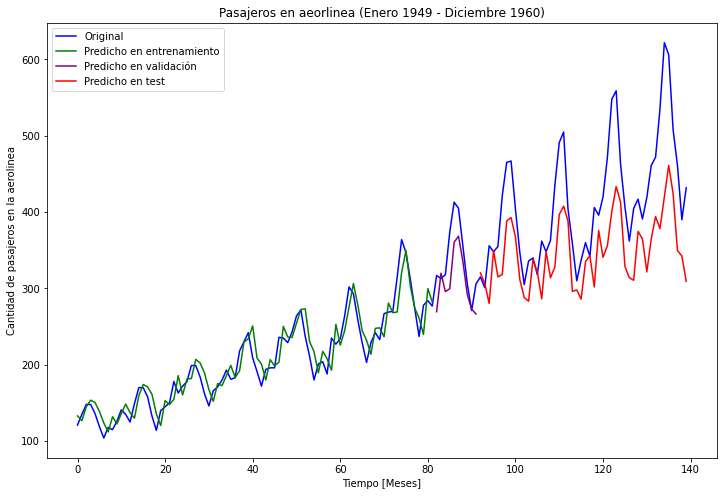

In [13]:
iter = 10
for j in range(iter):
  main(i=j, maxiter = iter-1)

Largo de la secuencia
* TEST_START_IDX = 92 - HISTORY_LENGTH

Size of train/val/test:  79 9 52


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0010: loss = 0.00312; val loss = 0.01050
Epoch #0020: loss = 0.00265; val loss = 0.00421
Epoch #0030: loss = 0.00225; val loss = 0.00621
Epoch #0040: loss = 0.00240; val loss = 0.00358
Epoch #0050: loss = 0.00191; val loss = 0.00389
Epoch #0060: loss = 0.00175; val loss = 0.00316
Epoch #0070: loss = 0.00168; val loss = 0.00247
Epoch #0080: loss = 0.00158; val loss = 0.00308
Epoch #0090: loss = 0.00173; val loss = 0.00269
Epoch #0100: loss = 0.00170; val loss = 0.00205
Epoch #0110: loss = 0.00166; val loss = 0.00357
Epoch #0120: loss = 0.00179; val loss = 0.00201
Epoch #0130: loss = 0.00180; val loss = 0.00269
Epoch #0140: loss = 0.00182; val loss = 0.00314
Epoch #0150: loss = 0.00161; val loss = 0.00410
Epoch #0160: loss = 0.00181; val loss = 0.00397
Epoch #0170: loss = 0.00171; val loss = 0.00498
Epoch #0180: loss = 0.00148; val loss = 0.00313
Epoch #0190: loss = 0.00167; val loss = 0.00205
Epoch #0200: loss = 0.00154; val loss = 0.00219
Epoch #0210: loss = 0.00163; val loss = 

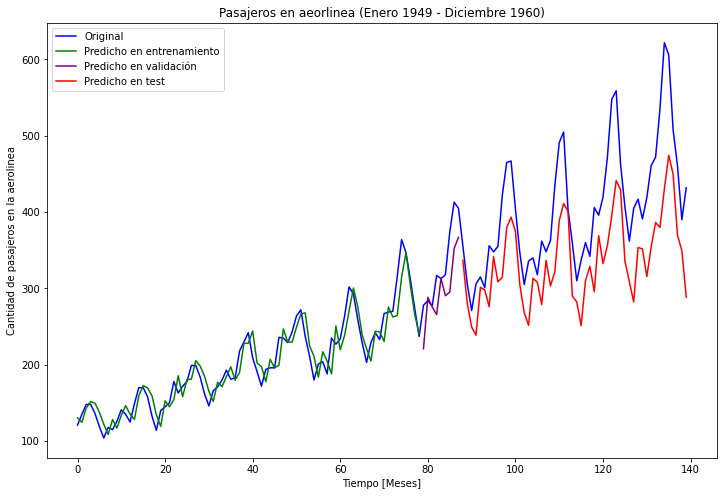

In [14]:
iter = 10
for j in range(iter):
  main(seq_len=92, i=j, maxiter=iter-1)

Capa full connected
* Capa fc de tamaño 100

Size of train/val/test:  79 9 52


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0010: loss = 0.00762; val loss = 0.06559
Epoch #0020: loss = 0.00210; val loss = 0.00865
Epoch #0030: loss = 0.00188; val loss = 0.00856
Epoch #0040: loss = 0.00175; val loss = 0.00633
Epoch #0050: loss = 0.00184; val loss = 0.00581
Epoch #0060: loss = 0.00161; val loss = 0.00511
Epoch #0070: loss = 0.00158; val loss = 0.00455
Epoch #0080: loss = 0.00168; val loss = 0.00576
Epoch #0090: loss = 0.00152; val loss = 0.00446
Epoch #0100: loss = 0.00198; val loss = 0.00251
Epoch #0110: loss = 0.00151; val loss = 0.00306
Epoch #0120: loss = 0.00148; val loss = 0.00517
Epoch #0130: loss = 0.00156; val loss = 0.00295
Epoch #0140: loss = 0.00152; val loss = 0.00521
Epoch #0150: loss = 0.00152; val loss = 0.00284
Epoch #0160: loss = 0.00160; val loss = 0.00277
Epoch #0170: loss = 0.00147; val loss = 0.00282
Epoch #0180: loss = 0.00154; val loss = 0.00320
Epoch #0190: loss = 0.00172; val loss = 0.00297
Epoch #0200: loss = 0.00146; val loss = 0.00313
Epoch #0210: loss = 0.00151; val loss = 

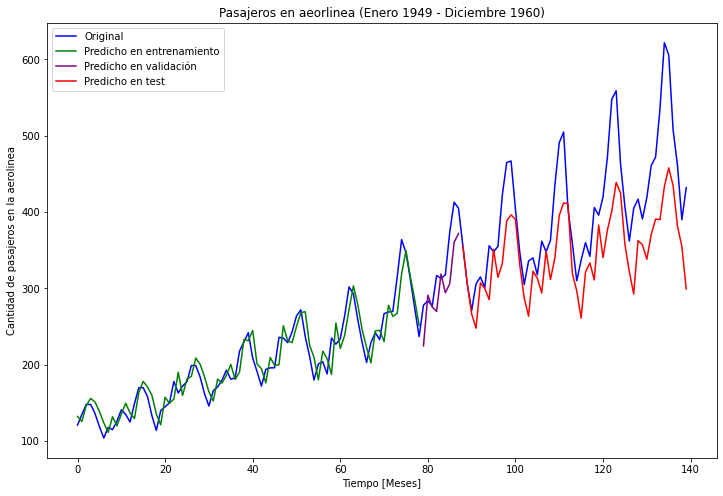

In [15]:
iter = 10
for j in range(iter):
  main(seq_len=92, rnn_type=3,i=j,maxiter = iter-1)

**Dropout**

A continuación con dropout
* Dropout de 0.3

Size of train/val/test:  79 9 52


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0010: loss = 0.00300; val loss = 0.01002
Epoch #0020: loss = 0.00214; val loss = 0.00307
Epoch #0030: loss = 0.00175; val loss = 0.00446
Epoch #0040: loss = 0.00166; val loss = 0.00198
Epoch #0050: loss = 0.00186; val loss = 0.00212
Epoch #0060: loss = 0.00159; val loss = 0.00201
Epoch #0070: loss = 0.00157; val loss = 0.00202
Epoch #0080: loss = 0.00162; val loss = 0.00264
Epoch #0090: loss = 0.00147; val loss = 0.00443
Epoch #0100: loss = 0.00170; val loss = 0.00329
Epoch #0110: loss = 0.00165; val loss = 0.00304
Epoch #0120: loss = 0.00191; val loss = 0.00456
Epoch #0130: loss = 0.00194; val loss = 0.00349
Epoch #0140: loss = 0.00156; val loss = 0.00391
Epoch #0150: loss = 0.00157; val loss = 0.00216
Epoch #0160: loss = 0.00160; val loss = 0.00307
Epoch #0170: loss = 0.00155; val loss = 0.00235
Epoch #0180: loss = 0.00159; val loss = 0.00519
Epoch #0190: loss = 0.00172; val loss = 0.00236
Epoch #0200: loss = 0.00162; val loss = 0.00318
Epoch #0210: loss = 0.00149; val loss = 

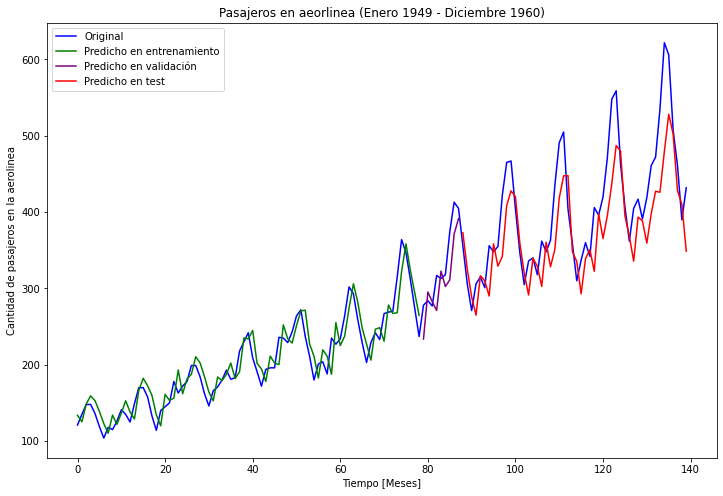

In [16]:
iter = 10
for j in range(iter):
  if __name__ == "__main__":
    main(seq_len=92, rnn_type=2, i=j, maxiter=iter-1)

#### Dropout de 0.5

Size of train/val/test:  79 9 52


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch #0010: loss = 0.00432; val loss = 0.04428
Epoch #0020: loss = 0.00260; val loss = 0.02091
Epoch #0030: loss = 0.00233; val loss = 0.01171
Epoch #0040: loss = 0.00213; val loss = 0.01001
Epoch #0050: loss = 0.00202; val loss = 0.01050
Epoch #0060: loss = 0.00201; val loss = 0.00829
Epoch #0070: loss = 0.00189; val loss = 0.00789
Epoch #0080: loss = 0.00185; val loss = 0.00733
Epoch #0090: loss = 0.00182; val loss = 0.00693
Epoch #0100: loss = 0.00188; val loss = 0.00679
Epoch #0110: loss = 0.00191; val loss = 0.00542
Epoch #0120: loss = 0.00178; val loss = 0.00608
Epoch #0130: loss = 0.00168; val loss = 0.00512
Epoch #0140: loss = 0.00167; val loss = 0.00518
Epoch #0150: loss = 0.00162; val loss = 0.00429
Epoch #0160: loss = 0.00160; val loss = 0.00470
Epoch #0170: loss = 0.00159; val loss = 0.00365
Epoch #0180: loss = 0.00154; val loss = 0.00418
Epoch #0190: loss = 0.00159; val loss = 0.00303
Epoch #0200: loss = 0.00160; val loss = 0.00332
Epoch #0210: loss = 0.00143; val loss = 

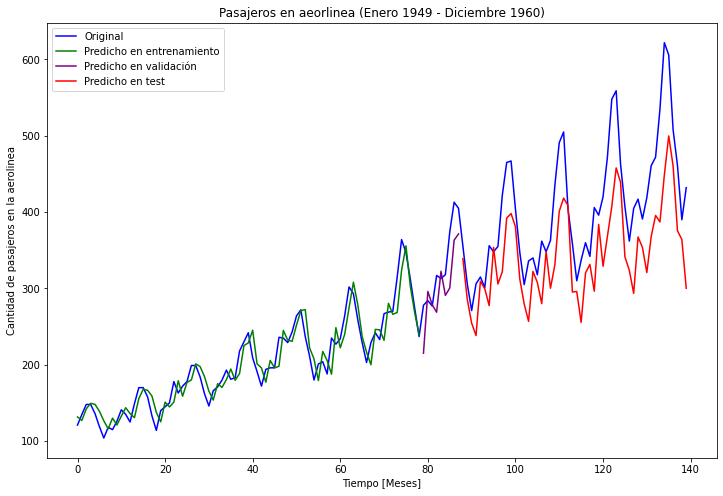

In [17]:
iter = 10
for j in range(iter):
  if __name__ == "__main__":
    main(seq_len=92, rnn_type=2, drop=0.5,i=j, maxiter = iter-1)

## 1.3 LSTM en vez de RNN

In [18]:
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
from math import sqrt

In [102]:
data_csv = pd.read_csv('international-airline-passengers.csv', usecols=[1])
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [20]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [21]:
data_X, data_Y = create_dataset(dataset)
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [22]:
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_Y)

Clase LSTM

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(LSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x) 
        s, b, h = x.shape # (seq, batch, hidden)
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

Main para LSTM

In [24]:
# A continuación se definen un par de constantes
DATASET_PATH = "international-airline-passengers.csv"
HISTORY_LENGTH = 4 # MANTENER
TEST_START_IDX = 92 - HISTORY_LENGTH
VAL_SPLIT = 0.1

INPUT_DIM = 2
HIDDEN_DIM = 4
NUM_LAYERS = 1 # SE PUEDE CAMBIAR 

EPOCHS = 1000
BATCH_SIZE = 32 # CAMBIABLE
LEARNING_RATE = 0.05

# Se instancia el modelo, pérdida y optimizador
lstm = LSTM(
        input_size=INPUT_DIM,
        hidden_size=HIDDEN_DIM)
#lstm.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)    


In [25]:
start_time = time.perf_counter()
for e in range(EPOCHS):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    out = lstm(var_x)
    loss = criterion(out, var_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data.item()))

print(f'Tiempo de ejecución = {time.perf_counter() - start_time:.4f} ')

Epoch: 100, Loss: 0.00340
Epoch: 200, Loss: 0.00148
Epoch: 300, Loss: 0.00082
Epoch: 400, Loss: 0.00055
Epoch: 500, Loss: 0.00042
Epoch: 600, Loss: 0.00039
Epoch: 700, Loss: 0.00051
Epoch: 800, Loss: 0.00032
Epoch: 900, Loss: 0.00028
Epoch: 1000, Loss: 0.00037
Tiempo de ejecución = 27.8290 


In [26]:
lstm = lstm.eval()

In [78]:
data_X = torch.tensor(data_X.reshape(-1, 1, 2))
var_data = Variable(data_X)
pred_test = lstm(var_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [96]:
dataset = np.reshape(dataset,(1,144))
pred_test = np.reshape(pred_test,(1,142))
# Se agregan ceros a la cola para que calcen las dimensiones
pred_test= np.block([np.zeros((1,2)),pred_test])

In [97]:
#pred_test = pred_test.view(-1).data.numpy()
data = data_X.numpy()
rmse = sqrt(mean_squared_error(dataset[0:142],pred_test))
# Calcula el RMSE para los datos normalizados
print(f"Test RMSE normalizado: {rmse:.4f}")

Test RMSE: 0.0584


In [106]:
pred_test = lstm(var_data)
pred_test = pred_test.view(-1).data.numpy()

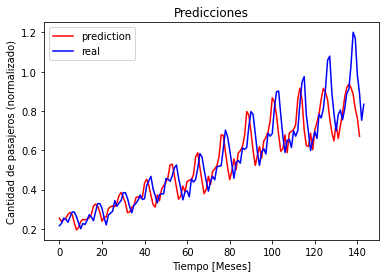

In [107]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')
plt.title('Predicciones')
plt.ylabel('Cantidad de pasajeros (normalizado)')
plt.xlabel('Tiempo [Meses]')
plt.show()

#### ARIMA

In [44]:
# Se importa la librería que contiene el modelo ARIMA
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
# Hiperparámetros de ARIMA
p = 4
d = 0
q = 4

data = pd.read_csv("international-airline-passengers.csv")
data.columns.values[1]

'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=475.158562, expected=112.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=-19.390526, expected=118.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=88.871012, expected=132.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=232.309515, expected=129.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=158.840477, expected=121.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=37.739876, expected=135.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=200.328347, expected=148.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=179.637900, expected=148.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=107.748570, expected=136.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=147.596873, expected=119.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=161.378338, expected=104.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=85.034998, expected=118.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=118.253055, expected=115.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=157.067493, expected=126.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=126.232567, expected=141.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=130.137063, expected=135.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=166.656194, expected=125.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=124.468998, expected=149.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=176.622284, expected=170.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=173.080435, expected=170.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=154.055572, expected=158.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=166.224757, expected=133.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=154.266430, expected=114.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=135.690655, expected=140.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=146.304579, expected=145.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=144.604715, expected=150.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=166.457777, expected=178.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=188.717799, expected=163.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=158.477045, expected=172.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=184.299523, expected=178.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=186.986809, expected=199.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=199.256658, expected=199.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=202.426035, expected=184.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=191.402760, expected=162.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=161.559593, expected=146.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=147.968922, expected=166.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=179.654871, expected=171.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=176.540154, expected=180.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=181.227303, expected=193.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=201.395494, expected=181.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=186.821981, expected=183.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=182.487067, expected=218.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=224.667641, expected=230.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=239.120739, expected=242.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=240.075337, expected=209.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=203.931286, expected=191.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=196.039043, expected=172.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=173.534404, expected=194.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=197.885933, expected=196.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=201.924152, expected=196.000000
predicted=200.140798, expected=236.000000
predicted=239.963788, expected=235.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=238.951178, expected=229.000000
predicted=228.038419, expected=243.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=242.337050, expected=264.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=270.549324, expected=272.000000
predicted=272.125189, expected=237.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=227.376666, expected=211.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=209.934125, expected=180.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=183.863791, expected=201.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=205.140078, expected=204.000000
predicted=206.843225, expected=188.000000
predicted=190.976499, expected=235.000000
predicted=240.775424, expected=227.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=229.971927, expected=234.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=234.116094, expected=264.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=265.313943, expected=302.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=309.742158, expected=293.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=287.736257, expected=259.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=246.713734, expected=229.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=228.084565, expected=203.000000
predicted=206.165803, expected=229.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=229.981706, expected=242.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=245.923595, expected=233.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=235.656566, expected=267.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=266.193486, expected=269.000000
predicted=270.399681, expected=270.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=270.978834, expected=315.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=313.545499, expected=364.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=369.203916, expected=347.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=340.144177, expected=312.000000
predicted=293.806610, expected=274.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=267.291487, expected=237.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=239.030794, expected=278.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=277.929852, expected=284.000000
predicted=283.314429, expected=277.000000
predicted=278.139859, expected=317.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=313.900332, expected=313.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=310.823662, expected=318.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=316.596607, expected=374.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=370.942121, expected=413.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=414.749189, expected=405.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=394.899166, expected=355.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=331.450150, expected=306.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=295.733282, expected=271.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=269.785995, expected=306.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=305.650833, expected=315.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=312.708243, expected=301.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=298.906680, expected=356.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=354.163337, expected=348.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=343.680360, expected=355.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=351.390079, expected=422.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=416.427919, expected=465.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=468.155760, expected=467.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=455.846003, expected=404.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=371.546691, expected=347.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=334.091307, expected=305.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=301.329770, expected=336.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=332.851778, expected=340.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=335.241041, expected=318.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=314.741649, expected=362.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=357.376566, expected=348.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=342.345177, expected=363.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=363.415764, expected=435.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=430.703916, expected=491.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=494.110997, expected=505.000000
predicted=495.802128, expected=404.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=362.829684, expected=359.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=345.254322, expected=310.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=308.016532, expected=337.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=336.325341, expected=360.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=351.734137, expected=342.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=341.712122, expected=406.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=406.924839, expected=396.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=382.212518, expected=420.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=418.989014, expected=472.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=466.548358, expected=548.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=551.881407, expected=559.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=545.167687, expected=463.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=422.808861, expected=407.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=384.516633, expected=362.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=357.832548, expected=405.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=407.819424, expected=417.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=402.750887, expected=391.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=382.226556, expected=419.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=414.095557, expected=461.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=460.210817, expected=472.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=464.781779, expected=535.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=527.519064, expected=622.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=627.023228, expected=606.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=590.442028, expected=508.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=457.501191, expected=461.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=438.902267, expected=390.000000
predicted=385.303799, expected=432.000000
Test RMSE: 47.458
Tiempo de ejecución = 131.7742 [s]


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


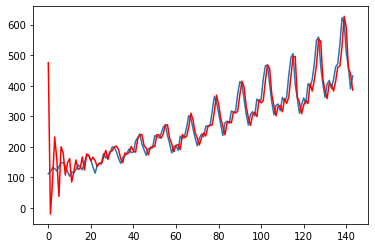

In [46]:
X = data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()
# walk-forward validation
t0 = time.perf_counter()
for t in range(len(X)):
	model = ARIMA(history, order=(4,0,4))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(X, predictions))
print('Test RMSE: %.3f' % rmse)
print(f'Tiempo de ejecución = {time.perf_counter() - t0:.4f} [s]')
# plot forecasts against actual outcomes
pyplot.plot(X)
pyplot.plot(predictions, color='red')
pyplot.show()

In [49]:
# Tamaño del modelo
np.shape(model.start_params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(10,)